# BDM Exam Project - Part 2

## TODO:
TASK 0:
- ridurre precisione (forse) per la generazione dei simboli dell'alfabeto (deve generarne quanti ne chiedo io, non di più, quindi in caso contrario castrare)

TASK2 E 3:
 - tkms (semantiche latenti) deve essere calcolata come distanza euclidea e non fare la - fra matrice e vettore


## Imports

In [1]:
# General utils
import os
import shutil
import numpy as np

# per i plot
import plotly.express as px
import plotly.graph_objects as go
# ---------- ---------- ---------- ---------- ----------

# My general utils
from my_utils import get_files_name, format_float
# ---------- ---------- ---------- ---------- ----------

# Task 0
from task0_utils import task0_stats
# Parte A
from task0_utils import generate_alphabet, gesture_2_word, write_word_as_json, generate_dizionario_parole_from_gesturewordsdict
# Parte B
from task0_utils import gesture_words_preprocessing, show_gesture_metrics
# ---------- ---------- ---------- ---------- ----------

# Task 1
from task1_utils import read_gesture_measures_reduced, metrics_reduced_2_numpy, metrics_numpy_2_pandas
from task1_utils import metrics_numpy_2_PCA, metrics_numpy_2_LDA, metrics_numpy_2_SVD
from task1_utils import get_top_k_latent_features, prepare_alg_variances_to_plot
# ---------- ---------- ---------- ---------- ----------

# Task 2
from task2_utils import generate_matrix_ed_dtw
from task2_utils import find_k_most_similar_dp, find_k_most_similar_tksem, find_k_most_similar_ed, find_k_most_similar_dtw
# ---------- ---------- ---------- ---------- ----------

# Task 3
from task3_utils import generate_gestures_similarity_matrix_dp, generate_gestures_similarity_matrix_tksem
from task3_utils import generate_gestures_similarity_matrix_ed, generate_gestures_similarity_matrix_dtw
from task3_utils import gestures_similarity_matrix_2_pandas, generate_gesture_gesture_svd, get_top_p_latent_gestures
# ---------- ---------- ---------- ---------- ----------

# Task 4
from task4_utils import cluster_labels_2_pandas, top_p_gestures_2_numpy
# Parte A
from task4_utils import MyPartitioner
# Parte B
from task4_utils import SimpleKMeans
# Parte C
from task4_utils import spectral_clustering_analyze, spectral_clustering
from task4_utils import spectral_analisys_results_2_pandas, spectral_analisys_results_pandas_2_split
# ---------- ---------- ---------- ---------- ----------

# Task 5
from task5_utils import database_numpy_2_supervised_data, test_knn_best_K, test_tree_best_depth

from sklearn.metrics import accuracy_score
# KNN classifier
from sklearn.neighbors import KNeighborsClassifier
# Decision Tree classifier
from sklearn import tree
import graphviz 
# ---------- ---------- ---------- ---------- ----------

## Task 0

In [2]:
path_csv_directory = '../Dati_2/csv/'

In [3]:
path_words_directory = '../Dati_2/words/'

In [4]:
path_vectors_directory = '../Dati_2/vectors/'

Inserire le coordinate che compongono il gesto separate da un trattino:

In [5]:
input_data_components = 'X-Y-Z-W'

Inserire un valore per R (2R è il numero di simboli dell'alfabeto)

In [6]:
input_interval_resolution = '6'

In [7]:
data_components = input_data_components.strip().split("-")
task0_stats["r"] = int(input_interval_resolution.strip())

# Rigenero i vari file path (per words e vectors)
if os.path.exists(path_words_directory):
    shutil.rmtree(path_words_directory)
os.makedirs(path_words_directory)
if os.path.exists(path_vectors_directory):
    shutil.rmtree(path_vectors_directory)
os.makedirs(path_vectors_directory)

In [8]:
# Mi prendo il nome di tutti i files
gesture_files = get_files_name(path_csv_directory + "X/", ext_filter="csv")
alfabeto = generate_alphabet(gesture_files, data_components, path_csv_directory, task0_stats)

In [9]:
print(alfabeto.simboli)
#print(alfabeto.parole)
print("Numero simboli:", alfabeto.n_simboli)
print("Numero parole:", alfabeto.n_parole)

{'0.24752': (0.0, 0.49505), '-0.24752': (0.0, -0.49505), '0.65634': (0.49505, 0.81763), '-0.65634': (-0.49505, -0.81763), '0.88609': (0.81763, 0.95456), '-0.88609': (-0.81763, -0.95456), '0.97348': (0.95456, 0.9924), '-0.97348': (-0.95456, -0.9924), '0.9958': (0.9924, 0.9992), '-0.9958': (-0.9924, -0.9992), '0.9996': (0.9992, 0.99999), '-0.9996': (-0.9992, -0.99999), '1.00002': (0.99999, 1.0), '-1.00002': (-0.99999, -1.0)}
Numero simboli: 14
Numero parole: 1277


### Task 0A

In [10]:
dizionario_gesti_parole = {}

for gesture_file_name in gesture_files:
    gesture_words_dict = gesture_2_word(gesture_file_name, data_components, alfabeto, path_csv_directory, task0_stats)
    # Salvo solo le info necessarie relative alle parole (come richiesto nel testo)
    dizionario_parole_gesture = generate_dizionario_parole_from_gesturewordsdict(gesture_words_dict)
    dizionario_gesti_parole[gesture_file_name.split(".")[0]] = dizionario_parole_gesture
    # Salvo su file il dizionario completo
    write_word_as_json(gesture_words_dict, gesture_file_name, path_words_directory)

In [11]:
#dizionario_gesti_parole['1']

### Task 0B

In [12]:
# Mi prendo la lista di tutti i file words
words_files = get_files_name(path_words_directory, ext_filter="wrd")

# CALCOLARE IL NUMERO DI SENSORI (anche se so che ce ne sono 20, in questo modo rimane più parametrico)
n_sensori = 0
for (_, sensor, word), cont in dizionario_gesti_parole[next(iter(dizionario_gesti_parole))].items():
    sensor = int(sensor)
    if n_sensori > sensor: # ho già ciclato una volta su tutti i sensori, è inutile ricontrollare per le altre coordinate
        break
    if n_sensori < sensor:
        n_sensori = sensor
n_sensori += 1 # Correzione dato che i sensori partono da 0 e a me serve sapere quanti ce ne sono

# Eseguo x il nostro dataset
t0b_preprocessing_settings = {
    'dizionario_gesti_parole': dizionario_gesti_parole,
    'data_components': data_components,
    'words_files': words_files,
    'n_sensori': n_sensori,
    'alfabeto': alfabeto,
    'path_words_directory': path_words_directory,
    'path_vectors_directory': path_vectors_directory # mettere a None o a caso se si mette save=False nel metodo
}
# Calcolo TF, IDF, TF-IDF di ogni gesto
gestures_metrics = gesture_words_preprocessing(t0b_preprocessing_settings)

In [13]:
#show_gesture_metrics(gestures_metrics[0])

## Task 1

In [14]:
input_task1_gesti_directory = '../Dati_2/csv/'

In [15]:
input_task1_data_components = 'X-Y-W-Z'

In [16]:
input_task1_modello_vettoriale = 'Modello TF-IDF'

In [17]:
t1_data_components = input_task1_data_components.strip().split("-")
t1_gesture_files = get_files_name(input_task1_gesti_directory + t1_data_components[0] + "/", ext_filter="csv")
# Dovremmo eseguire a tutti questi i 2 metodi gesture_2_word e poi word_2_metrics
# Ma ipotizziamo che siano i dati già calcolati ed evitiamo
t1_gesture_files = [g_file.split(".")[0] for g_file in t1_gesture_files] # mi prendo giusto il nome dei vari files

# 1260 con dimensione dei dati (n_sensori * n_parole)
t1_metrics_data = {
    'filename': [],
    'labels': [],
    'data': np.zeros((len(t1_gesture_files), n_sensori * alfabeto.n_parole))
}
for index, gesture_file in zip(range(len(t1_gesture_files)), t1_gesture_files):
    #path_vectors_directory = ../Dati_2/vectors/
    # Leggo le metrice ridotte
    gesture_metrics_reduced = read_gesture_measures_reduced(gesture_file, path_vectors_directory, input_task1_modello_vettoriale)
    # Trasformo la metrica ridotta in un file numpy
    label = 1 # Label 1 per i file 250, 280
    if int(gesture_file) < 100:
        label = 0 # Label 0 per file 1, 30
    elif int(gesture_file) > 400:
        label = 2 # label 2 per i file 560, 590
    metrics_numpy = metrics_reduced_2_numpy(gesture_metrics_reduced, alfabeto)
    t1_metrics_data['filename'].append(gesture_file)
    t1_metrics_data['labels'].append(label)
    t1_metrics_data['data'][index] = metrics_numpy

In [18]:
#t1_metrics_data

In [19]:
input_task1_option = 'LDA'

In [20]:
metrics_pandas = metrics_numpy_2_pandas(t1_metrics_data['data'], alfabeto)
if input_task1_option == "PCA":
    t1_alg_result, t1_alg_variance = metrics_numpy_2_PCA(metrics_pandas, show_intermediate_data=True)
elif input_task1_option == "SVD":
    t1_alg_result, t1_alg_variance = metrics_numpy_2_SVD(metrics_pandas, show_intermediate_data=True)
else:
    t1_alg_result, t1_alg_variance = metrics_numpy_2_LDA(metrics_pandas, t1_metrics_data['labels'], show_intermediate_data=True)

# Preparo i dati x il task 5 di classificazione che sarà fatto dai dati con dimensionalità ridotta generati qua
t5_data = {
    'data': t1_alg_result['fitted_alg'], 
    'labels': t1_metrics_data['labels']
}

,PC1,PC2,PC3
S0 -0.9996;-0.9996;-0.9996;-0.9996;-0.9996,6.720342e-19,9.179753e-19,1.590009e-18
S0 0.88609;0.97348;0.65634;0.88609;0.88609,1.248449e-17,6.451246e-20,1.254900e-17
S0 -0.88609;-0.65634;-0.65634;-0.65634;-0.88609,9.121424e-18,3.861156e-18,1.298258e-17
S0 0.88609;0.97348;0.9958;0.97348;0.9958,6.781317e-18,1.823301e-18,4.958016e-18
S0 0.9958;0.9958;0.9958;0.97348;0.9958,3.518486e-18,2.149916e-18,1.368570e-18
...,...,...,...
S19 -0.65634;-0.88609;-0.88609;-0.88609;0.88609,0.000000e+00,0.000000e+00,0.000000e+00
S19 1.00002;0.88609;0.65634;0.65634;0.24752,0.000000e+00,0.000000e+00,0.000000e+00
S19 0.9996;1.00002;0.9996;0.9958;0.9958,0.000000e+00,0.000000e+00,0.000000e+00
S19 0.97348;0.97348;-1.00002;0.88609;0.88609,0.000000e+00,0.000000e+00,0.000000e+00



PC1 top 10 features are: 



['S5 0.97348;0.97348;0.97348;0.97348;0.97348:     52.156894',
 'S8 0.9958;0.9958;0.9958;0.9958;0.9958:     51.492222',
 'S10 0.9958;0.9958;0.9958;0.9958;0.9958:     37.806571',
 'S9 0.97348;0.97348;0.97348;0.97348;0.97348:     25.365764',
 'S4 0.9958;0.9958;0.9958;0.9958;0.9958:     18.975306',
 'S3 0.88609;0.88609;0.97348;0.97348;0.97348:     16.732574',
 'S6 -0.24752;-0.65634;-0.65634;-0.65634;-0.65634:     16.340106',
 'S0 -0.88609;-0.88609;-0.88609;-0.88609;-0.88609:     16.053318',
 'S17 -0.65634;-0.24752;-0.24752;-0.24752;-0.24752:     15.089386',
 'S0 -0.24752;-0.24752;-0.24752;-0.24752;-0.65634:     14.33928']

In [21]:
fig = px.scatter(t1_alg_variance,
            labels={"index": "# Components", "value": "Explained Variance"}, 
            title="Explained Variance with increasing number of latent features")
fig.update_traces(showlegend=True)
fig.show()

In [22]:
t1_top_k_latent_features = '2'

In [23]:
t1_top_k_latent_features = int(t1_top_k_latent_features)
top_k_features = get_top_k_latent_features(t1_alg_result, t1_top_k_latent_features)
#top_k_features

## Task 2

 Scrivere un programma che, dato un file di gesti, individui i 10 gesti piu’ simili nel database di gesti, 
utilizzado:

In [24]:
# Preparazione data
t2_data_dp = {'gestures': t1_metrics_data['filename'], 'data': t1_metrics_data['data']}
t2_data_tksem = {'gestures': t1_metrics_data['filename'], 'data': t1_alg_result['fitted_alg']}

t2_data_ed_dtw = generate_matrix_ed_dtw([path_words_directory + word_file for word_file in words_files])
t2_data_ed = {'gestures': t1_metrics_data['filename'], 'data': t2_data_ed_dtw['ed']}
t2_data_dtw = {'gestures': t1_metrics_data['filename'], 'data': t2_data_ed_dtw['dtw']}

In [25]:
t2_input_file_gestures = '../Dati_2/words/1.wrd'

In [26]:
t2_input_k_gestures = '10'

In [27]:
t2_input_k_latent_features = '5'

In [28]:
t2_input_query_type = 'Dot Product'

In [29]:
# X facilità so che già ho calcolato sto file in input e lo prendo dal database
gesture_name_id = t2_input_file_gestures.split("/")[-1].split(".")[0]

query_type = t2_input_query_type
finder_query_settings = {
    'k_latent_features': int(t2_input_k_latent_features),
    'k_gestures_return': int(t2_input_k_gestures),
}

top_k = None
if query_type == 'Dot Product':
    gesture_numpy = t2_data_dp['data'][t2_data_dp['gestures'].index(gesture_name_id)]
    top_k = find_k_most_similar_dp(t2_data_dp, gesture_numpy, finder_query_settings)
elif query_type == 'Top-K Semantiche Latenti':
    gesture_numpy = t2_data_tksem['data'][t2_data_tksem['gestures'].index(gesture_name_id)]
    # Preparo la query con gli input scelti dall'utente
    top_k = find_k_most_similar_tksem(t2_data_tksem, gesture_numpy, finder_query_settings)
elif query_type == 'Edit Distance':
    gesture_numpy = t2_data_ed['data'][t2_data_ed['gestures'].index(gesture_name_id)]
    top_k = find_k_most_similar_ed(t2_data_ed, gesture_numpy, finder_query_settings)
else:
    gesture_numpy = t2_data_dtw['data'][t2_data_dtw['gestures'].index(gesture_name_id)]
    top_k = find_k_most_similar_dtw(t2_data_dtw, gesture_numpy, finder_query_settings)

if top_k is not None:
    print("Top " + t2_input_k_gestures + " gestures più simili a '" + t2_input_file_gestures + "', usando '" + query_type + "':")
    print(top_k)

Top 10 gestures più simili a '../Dati_2/words/1.wrd', usando 'Dot Product':
  gesture  similarity
0       1    1.000000
1      16    0.153507
2      19    0.139012
3     570    0.113609
4     259    0.110434
5      28    0.094433
6     559    0.090113
7      25    0.083684
8     569    0.081485
9       9    0.080318


## Task 3

In [30]:
t3_input_query_type = 'Dot Product'

In [31]:
query_type = t3_input_query_type

# Creo la matrice di similarità gesture - gesture (in base a come ha scelto l'utente di procedere)
gesture_sim_matrix = None
if query_type == 'Dot Product':
    gesture_sim_matrix = generate_gestures_similarity_matrix_dp(t2_data_dp['data'])
elif query_type == 'Top-K Semantiche Latenti':
    gesture_sim_matrix = generate_gestures_similarity_matrix_tksem(t2_data_tksem['data'], int(t2_input_k_latent_features))
elif query_type == 'Edit Distance':
    gesture_sim_matrix = generate_gestures_similarity_matrix_ed(t2_data_ed['data'])
else:
    gesture_sim_matrix = generate_gestures_similarity_matrix_dtw(t2_data_dtw['data'])
# La trasformo in dataframe pandas (così ho anche il nome delle gestures a confronto nelle righe / colonne)
gestures_sim_matrix_pd = gestures_similarity_matrix_2_pandas(gesture_sim_matrix, t2_data_tksem['gestures'])
print("Matrice similarità gesture-gesture:")
gestures_sim_matrix_pd

Matrice similarità gesture-gesture:


,1,10,11,12,13,14,15,16,17,18,...,584,585,586,587,588,589,6,7,8,9
1,1.000000,0.020167,0.078743,0.056112,0.024666,0.060019,0.012832,0.153507,0.022436,0.041745,...,0.008759,0.011302,0.021313,0.014705,0.011497,0.019098,0.040257,0.044759,0.061418,0.080318
10,0.020167,1.000000,0.014097,0.016826,0.051006,0.034999,0.025663,0.034688,0.135088,0.027032,...,0.009132,0.056987,0.013349,0.008966,0.011827,0.033652,0.021803,0.020985,0.037679,0.037479
11,0.078743,0.014097,1.000000,0.056684,0.005831,0.018548,0.019203,0.131015,0.011618,0.012455,...,0.005907,0.005523,0.010127,0.005332,0.008459,0.005523,0.026164,0.025916,0.044795,0.012918
12,0.056112,0.016826,0.056684,1.000000,0.012148,0.041347,0.018450,0.081586,0.009709,0.037532,...,0.007361,0.004919,0.044785,0.006250,0.007243,0.005551,0.040802,0.007840,0.007315,0.018095
13,0.024666,0.051006,0.005831,0.012148,1.000000,0.035214,0.079164,0.030601,0.040135,0.102848,...,0.021942,0.033643,0.025240,0.059626,0.031347,0.050635,0.050379,0.073946,0.042999,0.041473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,0.019098,0.033652,0.005523,0.005551,0.050635,0.016554,0.014714,0.025558,0.012384,0.061641,...,0.007664,0.003433,0.063911,0.007397,0.055970,1.000000,0.003705,0.008661,0.006184,0.003750
6,0.040257,0.021803,0.026164,0.040802,0.050379,0.017951,0.002639,0.043756,0.008089,0.039645,...,0.005727,0.002923,0.002856,0.006135,0.025047,0.003705,1.000000,0.023017,0.019406,0.029131
7,0.044759,0.020985,0.025916,0.007840,0.073946,0.031198,0.013312,0.023086,0.009145,0.061864,...,0.010658,0.007442,0.004405,0.006779,0.009910,0.008661,0.023017,1.000000,0.061162,0.044941
8,0.061418,0.037679,0.044795,0.007315,0.042999,0.035013,0.005254,0.040655,0.014810,0.150258,...,0.005489,0.002883,0.003057,0.007328,0.007061,0.006184,0.019406,0.061162,1.000000,0.044305


In [32]:
# Faccio svd con 93 componenti (e poi mi prendo solo quelle che servono)
n_components = 92
svd_latent_gestures, svd_variance = generate_gesture_gesture_svd(gestures_sim_matrix_pd, n_components=n_components)

In [33]:
t3_query_top_p = '5'

In [34]:
t3_query_top_p = int(t3_query_top_p)
# Input value check
if t3_query_top_p < 1:
    t3_query_top_p = 1
elif t3_query_top_p > n_components:
    t3_query_top_p = n_components

# Tiro fuori le top p gestures latenti
top_p_gestures = get_top_p_latent_gestures(svd_latent_gestures, t3_query_top_p)

In [35]:
#top_p_gestures

## Task 4

In [36]:
t4_p_partitions = '3'

In [37]:
t4_p_partitions = int(t4_p_partitions)
# Input value check
if t4_p_partitions < 1:
    t4_p_partitions = 1

### Task 4A

Partizionamento top_p_gestures in base ai loro gradi di appartenenza alle p semantiche

In [38]:
# Preparo i dati
max_iterations = 100 # max numero di iterazioni

# Dati reali (le top p gestures appena calcolate)
# Essendo le top p gestures in un 'formato strano' le traduco in un array numpy (sono una lista di dizionari di liste)
X_train = top_p_gestures_2_numpy(top_p_gestures, t3_query_top_p, t1_metrics_data['filename'])
X_test = X_train[:10] # Prendo un dato a caso giusto x testare la predict
#X_test = [np.array([0.5, 0.2, 0.3, 0.7, 0.1])] # Un esempio a caso deve avere p dimensioni (se non presente fra i dati deve dare None)

# Semplice esempio di test su 2 dimensioni
#X_train = [np.array([1, 1]), np.array([2, 2]), np.array([3, 3]), np.array([4, 1]), np.array([1, 2]), np.array([-1, -2]), np.array([5, 2])]
#X_test = [np.array([4, 1]), np.array([4, 2])]

In [39]:
# Creo e fitto il partizionatore selezionando t4_p_partitions come numero di gruppi da creare
partitioner = MyPartitioner(t4_p_partitions, max_iterations=max_iterations)
partitioner.fit(X_train)
#partitioner.fit(gesture_sim_matrix)
print("Dimensione spazio:", partitioner.groups_space_dimension)
#print("Gruppi:\n", partitioner.groups)

Dimensione spazio: 5.445993583836909


In [40]:
print("Predizione gruppi:", partitioner.predict(X_test))

Predizione gruppi: [0, 2, 0, 0, 0, 2, 2, 0, 2, 0]


### Task 4B

Clustering matrice similarità gesture-gesture con un algoritmo basato sul k-means (scritto da noi)

In [41]:
# Settings del k-means
k = t4_p_partitions # numero clusters
min_tolerance = 0.1 #meno di 10% differenza va bene
max_iterations = 5 # max numero di iterazioni

# Preparo i dati x il clustering
X_train = gestures_sim_matrix_pd.to_numpy()
# Prendo parte dei dati x vedere poi dopo dove sono andati a finire (dovrebbero essere circa tutti nello stesso se prendo tipo i top 10)
#(poi dopo a causa dell'ordinamento lessicografico posso avere roba differente)
X_test = X_train[0:10] # Prendo tot elementi del training data e provo poi a predirli, o sotto predico un elemento nuovo

In [42]:
# Creazione e fit dell'algoritmo
kmean = SimpleKMeans(k=k, min_tolerance=min_tolerance, max_iterations=max_iterations)
kmean.fit(X_train)

In [43]:
# Predizione dati
predictions = kmean.predict(X_test)
print(predictions)

[0, 2, 0, 1, 0, 2, 2, 0, 2, 0]


### Task 4C

Clustering matrice similarità gesture-gesture con un algoritmo di clustering spettrale basato sulla matrice laplaciana

In [44]:
analysys_spectral_results = spectral_clustering_analyze(gestures_sim_matrix_pd, max_clusters=15)
analysys_spectral_results = spectral_analisys_results_2_pandas(analysys_spectral_results, gestures_sim_matrix_pd)

In [45]:
# Plot clusters sankey
source, target, value = spectral_analisys_results_pandas_2_split(analysys_spectral_results)
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = list(set(source).union(set(target))),
        color = "blue"
    ),
    link = dict(
        source = source,
        target = target,
        value = value
    )
)])

fig.update_layout(title_text="Spectral Clustering Evolution", font_size=10)
fig.show()

In [46]:
generated_cluster_labels = spectral_clustering(gestures_sim_matrix_pd, n_clusters=t4_p_partitions)#, offset=44) # Usare offset se vogliamo mostrare i nomi dei cluster mostrati nel sankey, offset=44 per n_clusters=10
clustering_labels = [str(elem) for elem in set(generated_cluster_labels)] # All the cluster names
cluster_labels_full = cluster_labels_2_pandas(generated_cluster_labels, gestures_sim_matrix_pd.columns)

In [47]:
print("Cluster Names:", clustering_labels)
print("\nClustering Result:\n", generated_cluster_labels)
## In caso si voglia far vedere per bene le accoppiate (Gesture X, Label Y)
print("\nClustering Results(full info):\n", cluster_labels_full)

Cluster Names: ['0', '1', '2']

Clustering Result:
 [0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 2 0 0 2 0 0
 2 2 2 0 2 2 0 2 2 2 2 2 2 2 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1]

Clustering Results(full info):
 [{'Gesture': '1', 'Label': 0}, {'Gesture': '10', 'Label': 0}, {'Gesture': '11', 'Label': 0}, {'Gesture': '12', 'Label': 0}, {'Gesture': '13', 'Label': 1}, {'Gesture': '14', 'Label': 0}, {'Gesture': '15', 'Label': 0}, {'Gesture': '16', 'Label': 0}, {'Gesture': '17', 'Label': 0}, {'Gesture': '18', 'Label': 0}, {'Gesture': '19', 'Label': 0}, {'Gesture': '2', 'Label': 0}, {'Gesture': '20', 'Label': 0}, {'Gesture': '21', 'Label': 2}, {'Gesture': '22', 'Label': 0}, {'Gesture': '23', 'Label': 0}, {'Gesture': '24', 'Label': 0}, {'Gesture': '249', 'Label': 0}, {'Gesture': '25', 'Label': 0}, {'Gesture': '250', 'Label': 2}, {'Gesture': '251', 'Label': 0}, {'Gesture': '252', 'Label': 0}, {'Gesture': '253', 'Label': 2}, {'Gestur

## Task 5 

In [48]:
# Preparazione dataset
# In task 1 avevo generato i dati utilizzabili qui che sono in
#t5_data = { 'data', 'labels' }
# Posso usare meno feature latenti facendo
n_features_latenti = 5
task_data = t5_data['data'][:,:n_features_latenti]
task_target = t5_data['labels']
# Genero il dataframe pandas a partire dai dati e dalle loro labels
(X_train_df, y_train_df), (X_test_df, y_test_df), features_names = database_numpy_2_supervised_data(task_data, task_target)

X_train = X_train_df.to_numpy()
y_train = y_train_df.values.ravel()
# Normalizzo i dati di test
X_test = X_test_df.to_numpy()
y_test = y_test_df.values.ravel()

### Classificazione con k-nearest neighbor

In [49]:
weight = 'distance'#'uniform', 'distance'
accuracy_data_df = test_knn_best_K(X_train, y_train, X_test, y_test, max_neighbors=len(X_train)+1, weights=weight)
fig = px.line(accuracy_data_df, x="# Neighbors", y="Accuracy", title='Life expectancy in Ugoland')
fig.show()

In [55]:
# Addestro il classificatore
n_neighbors = 19 # Numero di vicini che uso x decidere la label
classifier = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weight)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=19, weights='distance')

In [56]:
# Predico
y_pred = classifier.predict(X_test)
print("("+str(n_neighbors)+")NN - Predictions:\n", y_pred)
print("Reals:\n", y_test)
print("Accuracy", format_float(accuracy_score(y_test, y_pred)))

(19)NN - Predictions:
 [2. 1. 1. 0. 0. 0. 1. 1. 0. 2. 0. 0. 0. 2. 0. 0. 0. 1. 1. 2. 0. 2. 2. 2.
 0. 1. 1. 2.]
Reals:
 [2. 1. 1. 0. 0. 1. 0. 1. 2. 2. 0. 0. 2. 2. 2. 0. 0. 1. 1. 0. 0. 2. 2. 2.
 0. 1. 1. 1.]
Accuracy 0.75


### Classificazione con decision tree

In [57]:
accuracy_data_df = test_tree_best_depth(X_train, y_train, X_test, y_test, max_depth=20)
fig = px.line(accuracy_data_df, x="Depth", y="Accuracy", title='Life expectancy in Ugoland')
fig.show()

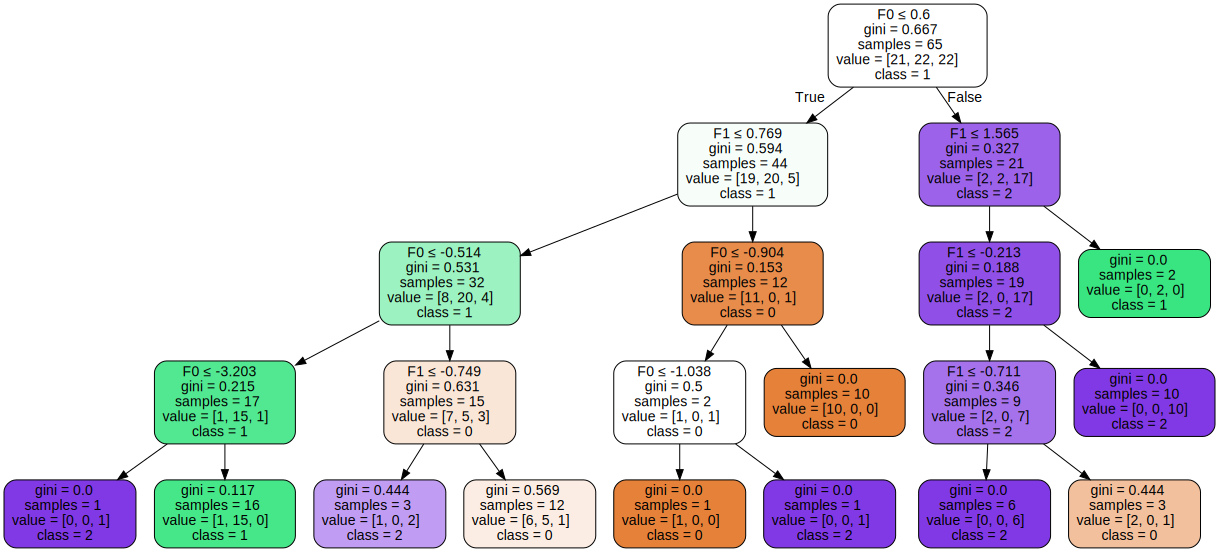

In [58]:
# Addestro l'albero di decisione
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_train, y_train)

# Eseguo il plot dell'albero di decisione creato
dot_data = tree.export_graphviz(clf, out_file=None,
    feature_names=features_names,
    class_names=[str(val) for val in set(t5_data['labels'])], #['Ugo', 'Federico', 'D.Va'],
    filled=True, rounded=True,
    special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [59]:
# Predico con l'albero di decisione
y_pred = clf.predict(X_test)
print("DT - Predictions:\n", y_pred)
print("Reals:\n", y_test)
print("Accuracy", format_float(accuracy_score(y_test, y_pred)))

DT - Predictions:
 [2. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 1. 1. 2. 0. 2. 0. 2.
 1. 1. 1. 2.]
Reals:
 [2. 1. 1. 0. 0. 1. 0. 1. 2. 2. 0. 0. 2. 2. 2. 0. 0. 1. 1. 0. 0. 2. 2. 2.
 0. 1. 1. 1.]
Accuracy 0.64286


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=81dda25b-3b1c-4959-acc8-4a8b980be717' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>